<a href="https://colab.research.google.com/github/Wachacha-jay/Computer_vision_Image_classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torchinfo

In [ ]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.2.1
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [ ]:
!pip install kagglehub

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Select your kaggle.json file

# Move the key to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("srg9000/cassava-plant-disease-merged-20192020")

print("Path to dataset files:", path)  # This will show where the dataset is stored

Path to dataset files: /kaggle/input/cassava-plant-disease-merged-20192020


In [ ]:
import shutil
import os

# Copy the dataset to a new location
destination = "./cassava_dataset"
if not os.path.exists(destination):
    shutil.copytree(path, destination)
    print(f"Dataset copied to {destination}")
else:
    print(f"{destination} already exists")

./cassava_dataset already exists


In [ ]:
destination

'./cassava_dataset'

In [ ]:
os.listdir(destination)

['train_images_tfrecords',
 'merged_train.csv',
 'extra_images',
 'extraimages_tfrecords',
 'train_images']

In [ ]:
data_dir = os.path.join(destination, 'merged_train.csv')

In [ ]:
import pandas as pd
df = pd.read_csv(data_dir)
df.head()

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4


In [ ]:
labels_dict = {
    0: 'Cassava Bacterial Blight (CBB)',
    1: 'Cassava Brown Streak Disease (CBSD)',
    2: 'Cassava Green Mottle (CGM)',
    3: 'Cassava Mosaic Disease (CMD)',
    4: 'Healthy'
}

# Add a new column 'disease_name' by mapping 'labels' to 'labels_dict'
df['disease_name'] = df['labels'].map(labels_dict)

# Display the updated DataFrame
df.head()

,image_id,labels,disease_name
0,723977410.jpg,3,Cassava Mosaic Disease (CMD)
1,3193577634.jpg,1,Cassava Brown Streak Disease (CBSD)
2,3349107107.jpg,3,Cassava Mosaic Disease (CMD)
3,2933959901.jpg,0,Cassava Bacterial Blight (CBB)
4,3020460837.jpg,4,Healthy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27053 entries, 0 to 27052
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      27053 non-null  object
 1   labels        27053 non-null  int64 
 2   disease_name  27053 non-null  object
dtypes: int64(1), object(2)
memory usage: 634.2+ KB


In [ ]:
train_path = os.path.join(destination, "train_images", "train_images")

In [ ]:
import os
import shutil
import pandas as pd

# ===== CONFIGURATION =====
source_folder = train_path  # Folder containing all your images
destination_root = "train"        # Main folder to be created


# ===== FOLDER CREATION =====
# Create main folder and subfolders (with existence checks)
os.makedirs(destination_root, exist_ok=True)  # Main 'train' folder
print(f"✅ Created main folder: {destination_root}/")

for disease in labels_dict.values():
    subfolder = os.path.join(destination_root, disease)
    os.makedirs(subfolder, exist_ok=True)
    print(f"  ├── Created subfolder: {disease}/")

# ===== IMAGE ORGANIZATION =====
success_count = 0
missing_count = 0

for _, row in df.iterrows():
    src = os.path.join(source_folder, row['image_id'])
    dest = os.path.join(destination_root, labels_dict[row['labels']], row['image_id'])

    try:
        shutil.copy2(src, dest)  # copy2 preserves metadata
        success_count += 1
    except FileNotFoundError:
        print(f"⚠️ Missing: {row['image_id']}")
        missing_count += 1
    except Exception as e:
        print(f"❌ Error copying {row['image_id']}: {str(e)}")

# ===== RESULTS SUMMARY =====
print("\n📊 Organization Complete!")
print(f"✅ Successfully copied: {success_count} files")
print(f"⚠️  Missing files: {missing_count}")
print(f"📁 Final structure in: {os.path.abspath(destination_root)}/")

✅ Created main folder: train/
  ├── Created subfolder: Cassava Bacterial Blight (CBB)/
  ├── Created subfolder: Cassava Brown Streak Disease (CBSD)/
  ├── Created subfolder: Cassava Green Mottle (CGM)/
  ├── Created subfolder: Cassava Mosaic Disease (CMD)/
  ├── Created subfolder: Healthy/

📊 Organization Complete!
✅ Successfully copied: 27053 files
⚠️  Missing files: 0
📁 Final structure in: /content/train/


In [ ]:
classes = os.listdir("/content/train")

In [ ]:
classes

['Cassava Brown Streak Disease (CBSD)',
 'Cassava Bacterial Blight (CBB)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy',
 'Cassava Green Mottle (CGM)']

In [ ]:
destination_root = os.path.join("/content/train")

In [ ]:
from pathlib import Path
destination_root = Path(destination_root)

In [ ]:
type(destination_root)

pathlib.PosixPath

In [ ]:
train_dir = list(destination_root.iterdir())
train_dir[0]

PosixPath('/content/train/Cassava Brown Streak Disease (CBSD)')

In [ ]:
healthy_dir =train_dir[0]
sample_img_path = list(healthy_dir.iterdir())[0]
sample_img_path

PosixPath('/content/train/Cassava Brown Streak Disease (CBSD)/344427708.jpg')

In [ ]:
#lets investigate one of the images in the healthy directory
sample_img = PIL.Image.open(sample_img_path)
sample_img
print(f"The image has a shape of: {sample_img.size}.")
print(f"The image has a mode of: {sample_img.mode}.")

In [ ]:
#Function to convert image to RGB
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [ ]:
#Now lets build a pipeline to convert images to RGB Resize them to a good size and convert the images to tensors
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
#Lets convert our directory into a dataset with the class labels representinting classes for doing our classification
dataset = datasets.ImageFolder(root=destination_root, transform=transform, target_transform=None)
dataset.classes

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

In [ ]:
#to investigate further how our dataset is arranged the dataset class has an attribute img which which returns path to our image and the class index
dataset.imgs[0]


('/content/train/Cassava Bacterial Blight (CBB)/1000015157.jpg', 0)

In [ ]:
#we can also investigate the class indexes with the attribute class_to index which returns a dictionary of classes mapped to the index
dataset.class_to_idx

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

In [ ]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']
That's 5 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [ ]:
#Normally we would work with the whole dataset but to make our work easier using pytorch it is reccomended we create a dataloader
batch_size = 32
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)

In [ ]:
#lets investigate our data loader our dataloader using iter and next
first_batch = next(iter(dataloader))
print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


## Now we have our loader to train our model but first
When we loop over this loader, it'll produce small batches of our images. This is what we want — these are the "minibatches" that will speed up our computations. In our case, each batch is  32  images, with each image  3  x  224  x  224 . It also provides us with the labels for the correct answers. This is the information we need to train a network. Normally we would split our data into training and validation test but to maximize our training accuracy pytorch works well with normalized data which is data with a mean of 0 and starndard deviation of 1, this is exactly what we are going to do, lets investigate our mean and starndard deviation then add them to our transform then we can split our training and validation sets

In [ ]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    #mean calculation
    mean = channels_sum / num_batches

    #std calculation
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std


In [ ]:
mean, std = get_mean_std(dataloader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.4340, 0.4967, 0.3152])
Standard deviation: tensor([0.2183, 0.2203, 0.2071])


Now tht we have the mean and starndard deviation we can go on and normalize our data, the beast way being doing it in the transformer oipeline

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

In [ ]:
dataset_norm = datasets.ImageFolder(root=destination_root, transform=transform_norm)

In [ ]:
norm_dataloader = DataLoader(dataset=dataset_norm, batch_size=batch_size)
first_batch_norm = next(iter(norm_dataloader))
print(f"Shape of one batch: {first_batch_norm[0].shape}")
print(f"Shape of labels: {first_batch_norm[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [ ]:
#lets look t the mean and std after our transformtion
mean, std = get_mean_std(norm_dataloader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([-2.0014e-07, -8.3626e-07, -1.6746e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


## Train and Validtion split
Now we will split our data into training and validtion when mking the dataloader to use in training our model. This will enable us assess the perfomance of our model

In [ ]:
genenerator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset_norm, [0.8, 0.2], generator=genenerator)
length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(dataset_norm)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


Now lets check the number of categories we have in each dataset, we know we had different numbers of categories distributed

In [ ]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


In [ ]:
#lets start with the training set
train_count = class_counts(train_dataset)
train_count

  0%|          | 0/21643 [00:00<?, ?it/s]

,0
Cassava Bacterial Blight (CBB),1241
Cassava Brown Streak Disease (CBSD),2879
Cassava Green Mottle (CGM),2535
Cassava Mosaic Disease (CMD),12698
Healthy,2290


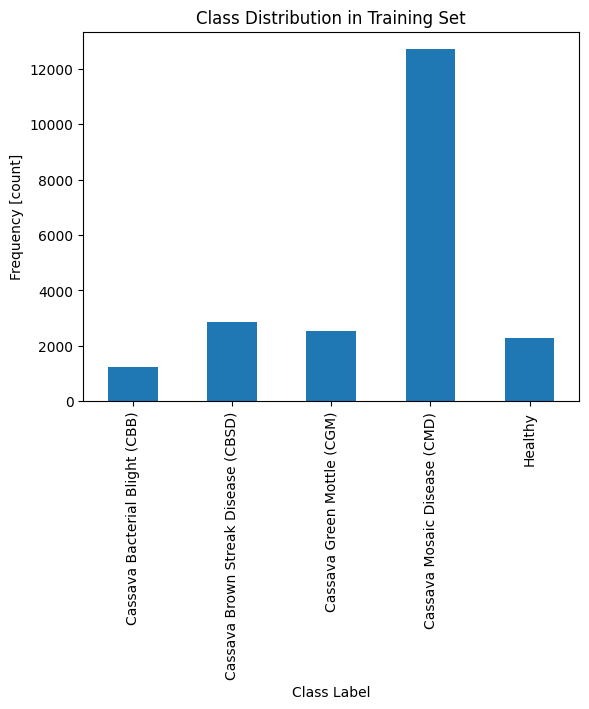

In [ ]:
#lets plot a bar chart to investigate the distribution this will be able to explain to us if we are dealing with imbalanced dta and the implictions to our model perfomance
train_count.plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

In [ ]:
#lets start with the training set
val_count = class_counts(val_dataset)
val_count

  0%|          | 0/5410 [00:00<?, ?it/s]

,0
Cassava Bacterial Blight (CBB),312
Cassava Brown Streak Disease (CBSD),753
Cassava Green Mottle (CGM),624
Cassava Mosaic Disease (CMD),3118
Healthy,603


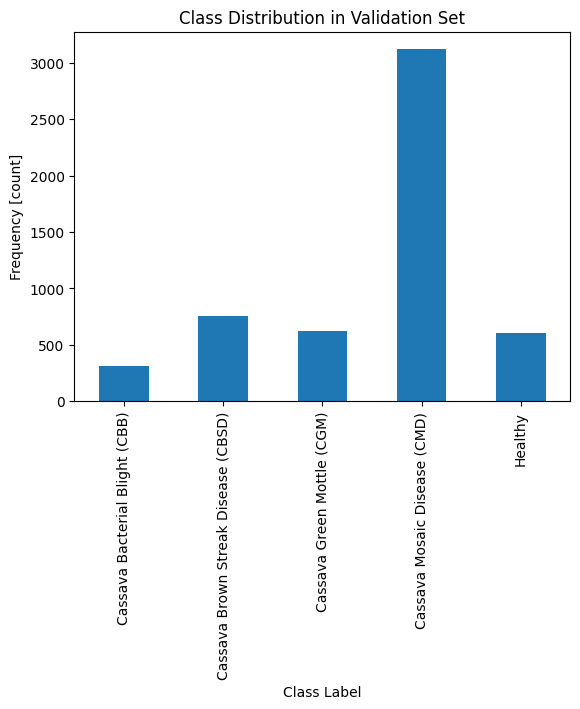

In [ ]:
#class distribution
val_count.plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

In [ ]:
#Now we are good lets build a training and validation loader, we will set shuffle True to only the training set
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=genenerator)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
single_batch = next(iter(train_dataloader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


## MODEL ARCHITECHTURE
Things are looking good we have our training and validation datAloader with a batchsize of 32 with images of 3 color channels and size of 224 by 224 now we are ready to move to the next step of bulding our model. Since we are dealing with  clasification problem we will build layers of convolution networks connected to a fully dense layer.

In [ ]:
#WE will build our model using sequential in the pytorch library
model_seq = torch.nn.Sequential()

1. We will create a convolution layer, pass in the number of channels in in our case 3 color channels and number of channels out, lets make it 16 a multiple of 2, use kernel_size of 3x3 and move a stride of 1
2. Pass an activation function in this case we will use Relu
3. then we will add a pooling lyer to reduce the output and in this case we will use maxpooling

In [ ]:
conv2d1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1)
model_seq.append(conv2d1)
model_seq.append(torch.nn.ReLU())
maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
model_seq.append(maxpool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
#Lets investigate with our test batch and see what we get
model_seq(single_batch).shape

torch.Size([32, 16, 111, 111])

We will add a convolution layer taking in our  16  channels and outputting  32  channels, with a  3  x  3  kernel and padding of  1 . Follow that with a ReLU, and a max pool of size  2  x  2.

In [ ]:
conv2d2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
model_seq.append(conv2d2)
model_seq.append(torch.nn.ReLU())
maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
model_seq.append(maxpool2)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
#Lets investigate with our test batch and see what we get after maxpool 2
model_seq(single_batch).shape

torch.Size([32, 32, 55, 55])

In [ ]:
#Lets add another layer of convolution network
conv2d3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
model_seq.append(conv2d3)
model_seq.append(torch.nn.ReLU())
maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
model_seq.append(maxpool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
#Lets investigate with our test batch and see what we get after maxpool 3
model_seq(single_batch).shape

torch.Size([32, 64, 27, 27])

We  are getting an out of 64 channel but for our dense layer we require a dimensional tensor which will be our batchsize and 64 x 27 x 27. For this we will flatten our otput using the flattening layer

In [ ]:
model_seq.append(torch.nn.Flatten())
model_seq(single_batch).shape

torch.Size([32, 46656])

At this point we have a flat input, and can build a normal set of dense layers. You can think of the convolution/max pool layers as having done the image processing. Now we need to do the actual classification. It turns out that dense layers are good at that task.

We could add a single layer and just go straight to our output $5$ classes. But we'll get better performance by adding a few dense layers, `Linear` in PyTorch's terminology, first. For these layers, we need to tell it the size of the input, and how many neurons we want in the layer. Since the input is our previous layer, we tell it that size. We'll add a layer of $500$ neurons.

In [ ]:
# But first lets add a Dropout layer
model_seq.append(torch.nn.Dropout(p=0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

In [ ]:
#Then we add  linear layer nd an activation function
model_seq.append(torch.nn.Linear(in_features=64*27*27, out_features=500))
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=46656, out_features=500, bias=True)
  (12): ReLU()
)

In [ ]:
#Now lets ensure we get our 500 AS OUR OUTPUT
model_seq(single_batch).shape

torch.Size([32, 500])

In [ ]:
#Now we will add an output layer to get our five classes but first lets add  dropout lyer then a linear output lyer with 5 neurons
model_seq.append(torch.nn.Dropout(p=0.5))
model_seq.append(torch.nn.Linear(in_features=500, out_features=5))
model_seq(single_batch).shape

torch.Size([32, 5])

Before we start training, let's put all the model code in one place. This is how you'd do it in practice, to prevent errors.

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=64*27*27, out_features=500),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=500, out_features=5)
)

To mke sure ou model out put is correct

In [ ]:
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 222, 222]        448
├─ReLU: 1-2                              [32, 16, 222, 222]        --
├─MaxPool2d: 1-3                         [32, 16, 111, 111]        --
├─Conv2d: 1-4                            [32, 32, 111, 111]        4,640
├─ReLU: 1-5                              [32, 32, 111, 111]        --
├─MaxPool2d: 1-6                         [32, 32, 55, 55]          --
├─Conv2d: 1-7                            [32, 64, 55, 55]          18,496
├─ReLU: 1-8                              [32, 64, 55, 55]          --
├─MaxPool2d: 1-9                         [32, 64, 27, 27]          --
├─Flatten: 1-10                          [32, 46656]               --
├─Dropout: 1-11                          [32, 46656]               --
├─Linear: 1-12                           [32, 500]                 23,328,500

## MODEL TRAINING

Now that we have finished building our model it time for trining according to our summry our model has over 23 million parameters. This will tke a long time to train, but first lets define the loss function and the optimizer we will be using. Since its a classification problem we will use Cross entropy and Adam optimizer

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Now lets crete our training function we will use a for loop to iterate through all the batches and epochs we will also be evaluating our model perfomance by calculating training and validation loss

In [ ]:
def trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, device):
  for epoch in tqdm(range(epochs)):
    train_loss = 0
    val_loss = 0
    val_correct = 0
    val_total = 0
    model.train()
    optimizer.zero_grad()
    for batch, (X, y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    with torch.no_grad():
      for batch, (X, y) in enumerate(val_dataloader):
        model.eval()
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        val_loss += loss.item()
        _, predicted = torch.max(y_pred.data, 1)
        val_total += y.size(0)
        val_correct += (predicted == y).sum().item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  return train_loss, val_loss

print()

now that this is complete we will train our model for 8 epochs

In [ ]:
trainer(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=8, device=device)


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8: Train Loss: 1.3399, Val Loss: 1.2667, Val Accuracy: 57.63%
Epoch 2/8: Train Loss: 1.2399, Val Loss: 1.2559, Val Accuracy: 57.63%
Epoch 3/8: Train Loss: 1.2344, Val Loss: 1.2553, Val Accuracy: 57.63%
Epoch 4/8: Train Loss: 1.2350, Val Loss: 1.2576, Val Accuracy: 57.63%
Epoch 5/8: Train Loss: 1.2347, Val Loss: 1.2555, Val Accuracy: 57.63%
Epoch 6/8: Train Loss: 1.2358, Val Loss: 1.2568, Val Accuracy: 57.63%
Epoch 7/8: Train Loss: 1.2363, Val Loss: 1.2594, Val Accuracy: 57.63%
Epoch 8/8: Train Loss: 1.2370, Val Loss: 1.2615, Val Accuracy: 57.63%


(1.237021285462767, 1.2615290021195131)

Judging by the above figures the model is performing poorly and this may be attributed to by various factures.
1. imbalanced data
2. Our model might be to shallow
So in the next trial we will try to undersample our dataset and also use a pretrained model from pytorch and see if our perfomance will improve but in the meanwhile lets sve our model.

In [ ]:
torch.save(model, "trained_model.pth")

In [ ]:
model = torch.load("trained_model.pth", weights_only=False)

Now lets use our model to make our predictions

In [ ]:
def predict(model, dataloader, device):
  model.eval()
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      _, predicted = torch.max(y_pred.data, 1)
      all_predictions.append(predicted.cpu())
      all_targets.append(y.cpu())

  return torch.cat(all_predictions), torch.cat(all_targets)

In [ ]:
predictions, targets = predict(model, dataloader=val_dataloader, device=device)
predictions[0]

tensor(3)

Now lets try to show try using our predictions to construct a confusion matrix but first we have to get the targets from the val loader

In [ ]:
# target = []
# for batch, (X, y) in enumerate(val_dataloader):
#   target.append(y)

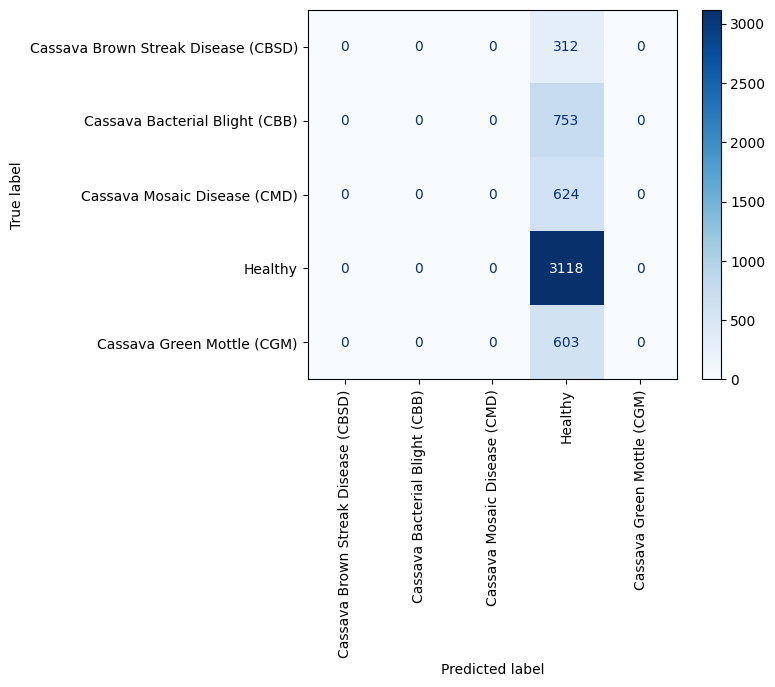

In [ ]:
#lets calculate values for our confusion matrix
cm = confusion_matrix(targets, predictions)

#lets plot our confusion matrix
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90) # Rotate x-axis labels
plt.show()

## CONCLUSION
As noted earlier, the model performance isn't great, likely due to the imbalanced dataset and potentially the model architecture.

Here are a few next steps we could consider:

1. Address data imbalance: You could try techniques like undersampling the majority class or oversampling the minority classes in your training data.
2. Experiment with a deeper model: Consider using a pre-trained convolutional neural network (CNN) like ResNet or VGG, which have shown great performance on image classification tasks. You could fine-tune it on your dataset.
2. Hyperparameter tuning: Experiment with different learning rates, optimizers, and batch sizes to see if you can improve model performance.